In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from re import sub
from decimal import Decimal
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.multicomp
from statsmodels.stats.anova import anova_lm
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
def substring_clean(new_df):
    new_df['bed'] = new_df['bed'].str.replace("Bedrooms:", "")
    new_df['bath'] = new_df['bed'].str.replace("Total Bathrooms:", "")
    new_df['property_type'] = new_df['property_type'].str.replace("Source Property Type:", "")
    new_df['property_type'] = new_df['property_type'].str.strip()
    new_df['House_Style'] = new_df['House_Style'].str.replace("House Style:", "")
    new_df['House_Style'] = new_df['House_Style'].str.split(',').str[0]
    new_df['House_Style'] = new_df['House_Style'].str.split(':').str[-1]
    new_df['House_Style'] = new_df['House_Style'].str.strip()
    new_df['sqft'] = new_df['sqft'].str.replace("sq ft", "")
    new_df['sqft'] = new_df['sqft'].str.replace(",", "")
    new_df['sqft'] = new_df['sqft'].str.replace("Lot ()", "")
    new_df['county'] = new_df['county'].str.replace("County:", "")
    
def loop_substring_clean(new_df):
    for ppsq in new_df['price_sq']:
        new_df['price_sq'] = new_df['price_sq'].str.replace("\n\nPrice/Sq Ft\n", "")
        new_df['price_sq'] = new_df['price_sq'].str.replace("\n", "")
        new_df['year built'] = new_df['year built'].str.replace("\n\nBuilt\n", "")
        new_df['year built'] = new_df['year built'].str.replace("\n", "")

def column_conversion(new_df):
    for i in range(0,len(new_df['price'])):
        if new_df['price'].iloc[i] == 'Contact For Price':
            new_df['price'].iloc[i] = 0
        else:
            new_df['price'].iloc[i] = new_df['price'].iloc[i].replace('$', '')
            new_df['price'].iloc[i] = new_df['price'].iloc[i].replace(',', '')
            
    
    new_df['price'] = new_df['price'].astype(int)
    new_df['bed'] = new_df['bed'].astype(int)
    new_df['bath'] = new_df['bath'].astype(int)
    
    

def price_conversion(new_df):
    for i in range(0,len(new_df['price_sq'])):
        if new_df['price_sq'].iloc[i] == 'No Info':
            new_df['price_sq'].iloc[i] = 0
        else:
            new_df['price_sq'].iloc[i] = new_df['price_sq'].iloc[i].replace('$', '')
            new_df['price_sq'].iloc[i] = new_df['price_sq'].iloc[i].replace(',', '')
       
    new_df['price_sq'] = new_df['price_sq'].astype(int)

def year_built(new_df):
    for i in range(0,len(new_df['year built'])):
        if len(new_df['year built'].iloc[i]) > 4:
            new_df['year built'].iloc[i] = 0
    

    new_df['year built'] = new_df['year built'].astype(int)

def sq_ft(new_df):
    for i in range(0,len(new_df['sqft'])):
        if len(new_df['sqft'].iloc[i]) < 4:
            new_df['sqft'].iloc[i] = 0 
        
    new_df['sqft'] = new_df['sqft'].astype(int)




In [3]:
def create_sold_data_convert(new_df):
    import json
    import ast
    test=[0]*len(new_df)
    for i in range(0,len(new_df['sold_data'])):
        extract = new_df["sold_data"].iloc[i]
        test[i] = ast.literal_eval(extract)
    new_df['sold_data_convert']=test

def create_price_diff(new_df):
    date_change=[0]*len(new_df)
    dc=0

    for data in new_df['sold_data_convert']:

        try:
            if data != []:
                if len(data) <2:
                    recent_date = data[0]
                    recent_date= datetime.strptime(recent_date['date'],'%m/%d/%Y')
                    today= datetime.strptime('07/04/2022','%m/%d/%Y')
                    date_change[dc]=(today- recent_date ).days
                   # dc+=1
                if len(data) > 2:
                    recent_date = data[0]
                    recent_date= datetime.strptime(recent_date['date'],'%m/%d/%Y')
                    last_date = data[-1]
                    last_date= datetime.strptime(last_date['date'],'%m/%d/%Y')
                    days= (recent_date - last_date).days
                    date_change[dc] = days
                   #dc+=1
            else:

                date_change[dc] = (0)
                #dc+=1
        except Exception as e:
            
            date_change[dc] = (0)
            #dc+=1
        dc +=1


    new_df['days_price_change'] = date_change

def create_first_last_date(new_df):
    recent=[0]*len(new_df)
    last=[0]*len(new_df)
    dc=0

    for data in new_df['sold_data_convert']:
        try:
            if data != []:
                if len(data) <2:
                    recent_date = data[0]
                    recent_date= datetime.strptime(recent_date['date'],'%m/%d/%Y')
                    today= datetime.strptime('07/04/2022','%m/%d/%Y')
                    recent[dc] = recent_date
                    last[dc] = recent_date
                    
                if len(data) > 2:
                    recent_date = data[0]
                    recent_date= datetime.strptime(recent_date['date'],'%m/%d/%Y')
                    last_date = data[-1]
                    last_date= datetime.strptime(last_date['date'],'%m/%d/%Y')
                    days= (recent_date - last_date).days
                    recent[dc] = recent_date
                    last[dc] = last_date
                    
            else:

                recent[dc] = (0)
                last[dc]= (0)
                
        except Exception as e:
            
            recent[dc] = (0)
            last[dc]= (0)
        dc+=1


    new_df['recent_date'] = recent
    new_df['latest'] = last
    

In [4]:
def create_prop_dict(new_df):
    
    manufactured = ['Double Wide Mobile Home','Manufactured w/o Land','Residential - Manufactured/Mobile','Manufactured w/Land','Single Family - Detached','Mobile','Double Wide Mobile Home','Single Wide Mobile Home','Triple Wide Mobile Home','Manufactured In Park','Manufactured Home','Manufactured On Land','Mfg/Mobile Housing']
    resident_income = ['Multifamily','Apartment Building','5-10 Units','Residential','Multi-level','resident_income','Five or More Units','Residential Income','Res Income 2-4 Units','MULT','resident_income']
    condo=['Condo/Townhm/Twin','Loft Style','Apartment Style/Flat','Residential - Condo/Townhouse','Condo','condo','COND','Condominium','Condo/Townhome']
    Plex=['Triplex','Bungalow/1.5 Story','Townhouse-2 Story, End Unit, Not a condo (Single Fam)','Fourplex','1 story, Shared Wall/HalfDuplex','Duplex','Four Plex','Duplex/2 Story','Duplex +','Duplex/2 Story, In-Law/Guest Quarter','Duplex-side by side','Bungalow/1.5 Story, In-Law/Guest Quarter','Ranch-1 Story, Shared Wall/Half duplex','Shared Wall/Half duplex','Tri-plex']
    
    Other=['Conversion','Subdivision','All Other Attached','Garden, End Unit','View of Water','2 flat-up and down','1 story, Under construction','2 story, Under construction','A','2 story, Multi-level','1 story, BldgPlan w/Lot','1 1/2 story, 2 story','1 1/2 story','2 story, BldgPlan w/Lot','Attached Dwelling','0','Attached','3 story, 2 flat-up and down','2 story','1 story','Townhouse-2 Story','Townhouse-2 Story, End Unit']
    Ranch = ['Land Developed','View of Water, Waterfrontage on Lot','Garden','Farm/Ranch','Land Undeveloped']
    Single_Family = ['Detached','Garden, Conversion','Townhouse-2 Story, Under Construction','Townhome','Townhouse','Single Family Site Built','Single Family Residence','Single Family']
    
    for i in range(0,len(new_df)):
        if new_df['property_type'].iloc[i] in manufactured:
            new_df['property_type'].iloc[i] = 'Manufactured'
        elif new_df['property_type'].iloc[i] in resident_income:
            new_df['property_type'].iloc[i] = 'resident_income'
        elif new_df['property_type'].iloc[i] in condo:
            new_df['property_type'].iloc[i] = 'Condo'
        elif new_df['property_type'].iloc[i] in Plex:
            new_df['property_type'].iloc[i] = 'Plex'
        elif new_df['property_type'].iloc[i] in Single_Family:
            new_df['property_type'].iloc[i] = 'Single_Family'
        elif new_df['property_type'].iloc[i] in Other:
            new_df['property_type'].iloc[i] = 'Other'
        elif new_df['property_type'].iloc[i] in Ranch:
            new_df['property_type'].iloc[i] = 'Ranch'
                      
            

    Dict= {
        'Single_Family': 1 , 'Manufactured': 2, 'resident_income': 3, 'Condo': 4,
       'Plex' : 5, 'Other': 6,
       'Ranch': 7 
       } 
  
    
    
    new= new_df.replace({"property_type": Dict})
    new_df["property_type_code"]=new_df['property_type'].map(Dict)
    
def create_city_dict(new_df):
    Dict={
        'San-Jose_CA':1 , 'Cupertino_CA': 2 , 'Anaheim_CA': 3, 'San-Diego_CA': 4,
       'Seattle_WA': 5, 'Bellevue_WA' : 6, 'Portland_OR': 7, 'Eugene_OR': 8,
       'Detroit_MI': 9, 'Royal-Oak_MI': 10, 'Farmington-Hills_MI': 11,
       'Birmingham_MI': 12, 'Dallas_TX': 13, 'Plano_TX': 14, 'Frisco_TX': 15,
       'Arlington_TX': 16,'Boulder_CO': 17, 'Denver_CO': 19, 'Chandler_AZ':20, 'Phoenix_AZ':21,
        'Santa-Fe_NM': 22, 'Albuquerque_NM': 23, 'Madison_WI':24, 'Milwaukee_WI' : 25, 'Rexburg_ID' : 26, 'Boise_ID': 28

    }
    
    new= new_df.replace({"city": Dict})
    new_df["city_code"]=new_df['city'].map(Dict)
    
    new_df['state_code'] = new_df['city'].str[-2:]
    


    
    
    
def create_house_style(new_df):
    
    manufactured = ['Double Wide','Single Wide','Mobile Home','Mobile/Manufactured','Manufactured with Land','Manufactured Home','Double Wide Manufactured']
    Rise=['Common Entry Building','Upper/Lower Apartment','High Rise','High Rise (8+)','Mid Rise (4-7)','Low Rise (1-3)']
    Plex=['Attached','Shared Wall/Half duplex','Common Wall','Triplex','Duplex','1/2 Duplex with Land']
    other=['Farmhouse','End Unit','Architectural Style','Saltbox','Fixer Upper','Composition','Split Entry','Units Over and Under','Live Work Unit','All Units in One Building','Separate Buildings','Conversion']
    Contemporary = ['Mountain Contemporary','Urban Contemporary','Contemporary','NW Contemporary']
    Townhome = ['Townhouse','Townhome','Split Level','Townhouse-2 Story']
    levels=['Bi-level','Tri Level','Stacked','3 Level','Tri-level','Tri-Level','4 Level',]
    Craftsman=['Craftsman','Prairie/Craftsman']
    Ranch=['Ranch','Ranch-1 Story']
    Traditional=['A-Frame','Patio Home','Traditional']
    House=['1 Story','2 Story','1.5 Story','House','Single Story']
    No_Description=['0','Garden','Detached']
    Modern = ['Eichler','Contemporary/Modern','Modern','Mid Century Modern','Mid-Century Modern']
    Luxury=['Luxury']
    Cape=['Cape Cod','Capecod']
    Mediterranean=['Mediterranean','Mediterranean/Mission/Spanish','Mediterranean/Spanish','Spanish','Tuscan']
    Victorian=['Victorian','French','Country French','Tudor']
    Colonial=['Garrison Colonial','Colonial']
    Southwestern=['North New Mexico','Northern New Mexico','Pueblo/SW','Territorial','Southwestern','Pueblo']
    Cottage=['Bungalow','Cottage/Bung','Cottage']
    Custom=['Custom Style','Custom']
    Condo=['Loft','Studio','Site Condo']
    


    
    
    for i in range(0,len(new_df)):
            if new_df['House_Style'].iloc[i] in manufactured:
                new_df['House_Style'].iloc[i] = 'Manufactured'
            elif new_df['House_Style'].iloc[i] in Rise:
                new_df['House_Style'].iloc[i] = 'Rise'
            elif new_df['House_Style'].iloc[i] in Plex:
                new_df['House_Style'].iloc[i] = 'Plex'
            elif new_df['House_Style'].iloc[i] in other:
                new_df['House_Style'].iloc[i] = 'Other'
            elif new_df['House_Style'].iloc[i] in Contemporary:
                new_df['House_Style'].iloc[i] = 'Contemporary'
            elif new_df['House_Style'].iloc[i] in Townhome:
                new_df['House_Style'].iloc[i] = 'Townhome'
            elif new_df['House_Style'].iloc[i] in levels:
                new_df['House_Style'].iloc[i] = 'levels'
            elif new_df['House_Style'].iloc[i] in Craftsman:
                new_df['House_Style'].iloc[i] = 'Craftsman'
            elif new_df['House_Style'].iloc[i] in Ranch:
                new_df['House_Style'].iloc[i] = 'Ranch'
            elif new_df['House_Style'].iloc[i] in Traditional:
                new_df['House_Style'].iloc[i] = 'Traditional'
            elif new_df['House_Style'].iloc[i] in Modern:
                new_df['House_Style'].iloc[i] = 'Modern'
            elif new_df['House_Style'].iloc[i] in Luxury:
                new_df['House_Style'].iloc[i] = 'Luxury'
            elif new_df['House_Style'].iloc[i] in Cape:
                new_df['House_Style'].iloc[i] = 'Cape'
            elif new_df['House_Style'].iloc[i] in Mediterranean:
                new_df['House_Style'].iloc[i] = 'Mediterranean'
            elif new_df['House_Style'].iloc[i] in Colonial:
                new_df['House_Style'].iloc[i] = 'Colonial'
            elif new_df['House_Style'].iloc[i] in Victorian:
                new_df['House_Style'].iloc[i] = 'Victorian'
            elif new_df['House_Style'].iloc[i] in Southwestern:
                new_df['House_Style'].iloc[i] = 'Southwestern'
            elif new_df['House_Style'].iloc[i] in Cottage:
                new_df['House_Style'].iloc[i] = 'Cottage'
            elif new_df['House_Style'].iloc[i] in Custom:
                new_df['House_Style'].iloc[i] = 'Custom'
            elif new_df['House_Style'].iloc[i] in Condo:
                new_df['House_Style'].iloc[i] = 'Condo'
            elif new_df['House_Style'].iloc[i] in No_Description:
                new_df['House_Style'].iloc[i] = 'No_Description'
            elif new_df['House_Style'].iloc[i] in House:
                new_df['House_Style'].iloc[i]= 'House'
            
    
    
    
    Dict = {
        'Other': 0, 'Manufactured': 1, 'Rise': 2, 'Plex': 3, 'Contemporary': 4, 'Townhome': 5,
       'levels': 6, 'Craftsman': 7, 'Ranch': 8, 'Traditional': 9,
       'Modern': 10, 'Luxury': 11, 'Cape': 12, 'Mediterranean': 13,
       'Colonial': 14, 'Victorian': 15, 'Southwestern': 16,
       'Cape': 17,'Townhome': 18, 'Cottage': 19,'Custom': 20, 'Condo': 21,'No_Description': 22, 'House': 23
    }
    new= new_df.replace({"House_Style": Dict})
    new_df["House_Style_Code"]=new_df['House_Style'].map(Dict)

In [5]:
def year_conversion(new_df):
    new_df['YEAR_DECADE'] = np.where((new_df['year_built'] > 1950) & (new_df['year_built'] < 1959), '1950 - 1959',
                                     np.where((new_df['year_built'] > 1960) & (new_df['year_built'] < 1969), '1960 - 1969',
                                              np.where((new_df['year_built'] > 1970) & (new_df['year_built'] < 1979), '1970 - 1979',
                                                       np.where((new_df['year_built'] > 1980) & (new_df['year_built'] < 1989), '1980 - 1989',
                                                                np.where((new_df['year_built'] > 1990) & (new_df['year_built'] < 1999), '1990 - 1999',
                                                                         np.where((new_df['year_built'] > 2000) & (new_df['year_built'] < 2009), '2000 - 2009',
                                                                                  np.where((new_df['year_built'] > 2010) & (new_df['year_built'] < 2019), '2010 - 2019',
                                                                                           np.where((new_df['year_built'] > 2020) & (new_df['year_built'] < 2023), '2020 - 2022',
                                                                                                    np.where(new_df['year_built'] < 10, 'No Year Given','Before 1950')))))))))
    new_df['YEAR_DECADE_CODE'] = np.where(new_df['YEAR_DECADE'] == '1950 - 1959',1,
                                         np.where(new_df['YEAR_DECADE'] == '1960 - 1969',2,
                                                 np.where(new_df['YEAR_DECADE'] == '1970 - 1979',3,
                                                         np.where(new_df['YEAR_DECADE'] == '1980 - 1989',4,
                                                                 np.where(new_df['YEAR_DECADE'] == '1990 - 1999',5,
                                                                         np.where(new_df['YEAR_DECADE'] == '2000 - 2009',6,
                                                                                 np.where(new_df['YEAR_DECADE'] == '2010 - 2019',7,
                                                                                          np.where(new_df['YEAR_DECADE'] == '2020 - 2022',8,
                                                                                                   np.where(new_df['YEAR_DECADE'] == 'No Year Given',999,0)))))))))
                                             

In [6]:
def first_time_list(new_df):
    new_df['first_time_list'] = np.where(new_df['price_change']==0,'First_Time',"Not_First_Time")
    new_df['first_time_list_code'] = np.where(new_df['first_time_list'] == 'First_Time', 1,0)

def average_metrics(new_df):
    new_df['National_Price_Average'] = new_df['price'].mean()
    new_df['County_Price_Average'] = new_df['price'].groupby(new_df['county']).transform('mean')

def comparative_average(new_df):
    new_df['County_Over_National'] = new_df['County_Price_Average']/new_df['National_Price_Average']
    new_df['List_over_County'] = new_df['price']/new_df['County_Price_Average']
    new_df['List_over_National']=new_df['price']/new_df['National_Price_Average']


    

In [7]:
def fair_value(new_df):
    new_df['fair_value_flag'] = np.where((new_df['List_over_National'] < 1.0) & (new_df['County_Over_National'] < 1.0),1,0)



In [8]:
df1=pd.read_csv("Cupertino_CA.csv")
df2=pd.read_csv("San-Diego_CA.csv")
df3=pd.read_csv("Bellevue_WA.csv")
df4=pd.read_csv("Eugene_OR.csv")
df5=pd.read_csv("Royal-Oak_MI.csv")
df6=pd.read_csv("Birmingham_MI.csv")
df7=pd.read_csv("Plano_TX.csv")
df8=pd.read_csv("Arlington_TX.csv")
df9=pd.read_csv("Boulder_CO.csv")
df10=pd.read_csv("Chandler_AZ.csv")
df11=pd.read_csv("Santa-Fe_NM.csv")
df12=pd.read_csv("Madison_WI.csv")
df13=pd.read_csv("Boise_ID.csv")

frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
  
new_df = pd.concat(frames)
new_df=new_df.reset_index()

In [9]:
create_sold_data_convert(new_df)
create_price_diff(new_df)
create_first_last_date(new_df)
substring_clean(new_df)
loop_substring_clean(new_df)
column_conversion(new_df)
price_conversion(new_df)
year_built(new_df)
sq_ft(new_df)
create_prop_dict(new_df)
create_city_dict(new_df)
create_house_style(new_df)
first_time_list(new_df)
average_metrics(new_df)
comparative_average(new_df)
fair_value(new_df)


C:\Users\hsman\AppData\Local\Temp/ipykernel_15456/3348703082.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df['sqft'] = new_df['sqft'].str.replace("Lot ()", "")
C:\Users\hsman\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
final_df=new_df.drop(columns= ['index', 'Unnamed: 0', 'sold_data'])
final_df=final_df.rename(columns={"year built": "year_built"})
year_conversion(final_df)
final_df
final_df.to_csv("Final_df.csv")

In [11]:
test_df=final_df[final_df['price_change'] != 0 ]
test_df.groupby(['county'])['price_change'].median()

county
 55025           90.620
 Ada            153.685
 Arapahoe        29.560
 Bernalillo      73.700
 Boise           76.100
 Boulder         91.920
 Clackamas      211.420
 Collin         101.960
 Dallas          88.670
 Dane            68.100
 Denton          84.100
 Denver          45.405
 Fremont        146.820
 King           104.830
 Lane            91.710
 Madison         48.490
 Maricopa       156.300
 Milwaukee       26.560
 Multnomah      101.750
 Oakland         45.905
 Orange          93.315
 San Diego       93.870
 Santa Clara     85.000
 Santa Fe        74.740
 Tarrant         75.140
 Washington     106.175
 Wayne          199.990
Name: price_change, dtype: float64

In [12]:
test_df.groupby(['city'])['days_price_change'].mean()

city
Albuquerque_NM         3056.781818
Anaheim_CA             2127.541667
Arlington_TX           1312.102564
Bellevue_WA            1082.428571
Birmingham_MI          1985.430769
Boise_ID               2118.924528
Boulder_CO             1830.867925
Chandler_AZ            1769.653846
Cupertino_CA            891.900000
Dallas_TX              2140.258621
Denver_CO               338.760000
Detroit_MI             1781.086957
Eugene_OR              2278.370370
Farmington-Hills_MI    2050.255319
Frisco_TX              1910.217391
Madison_WI             1717.687500
Milwaukee_WI            965.650000
Phoenix_AZ             2096.265306
Plano_TX               1750.765957
Portland_OR            2455.041667
Rexburg_ID              620.104167
Royal-Oak_MI           2442.535714
San-Diego_CA           1923.120000
San-Jose_CA            2353.285714
Santa-Fe_NM            3153.111111
Seattle_WA             1241.368421
Name: days_price_change, dtype: float64

In [13]:
test_df.groupby(['county'])['price_change'].mean()

county
 55025           90.620000
 Ada            187.041851
 Arapahoe        31.048000
 Bernalillo      89.792346
 Boise           76.100000
 Boulder        107.502488
 Clackamas      211.420000
 Collin         422.338154
 Dallas         160.129649
 Dane            79.913404
 Denton         120.706207
 Denver          64.817500
 Fremont        146.820000
 King           119.837576
 Lane           127.745185
 Madison        130.872796
 Maricopa       239.154851
 Milwaukee      278.982380
 Multnomah       97.003529
 Oakland        271.103358
 Orange         107.390417
 San Diego      105.379600
 Santa Clara    118.054967
 Santa Fe       103.587111
 Tarrant        101.291795
 Washington     112.311667
 Wayne          654.163478
Name: price_change, dtype: float64

In [14]:
test_df.groupby(['YEAR_DECADE'])['price_change'].mean()

YEAR_DECADE
1950 - 1959      140.644442
1960 - 1969      201.585872
1970 - 1979      113.881410
1980 - 1989      126.050846
1990 - 1999      131.464714
2000 - 2009      252.751916
2010 - 2019      163.413696
2020 - 2022      231.721196
Before 1950      234.077116
No Year Given    124.478537
Name: price_change, dtype: float64

In [15]:
test_df.groupby(['first_time_list'])['price_change'].mean()

first_time_list
Not_First_Time    188.154728
Name: price_change, dtype: float64

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = final_df.select_dtypes(include=numerics)
newdf=newdf.dropna()
mat = newdf.values

In [17]:
year_df=final_df[(final_df['year_built'] != 0)]

<AxesSubplot:>

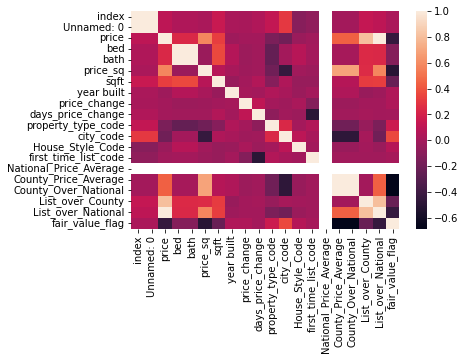

In [25]:
sns.heatmap(new_df.corr())

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
X=final_df[['sqft','bed','bath','property_type_code','House_Style_Code','city_code','year_built','County_Over_National']]
y=final_df['price']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

# Adding a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fitting the resgression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Printing the parameters
lr.params

C:\Users\hsman\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                  -570365.110625
sqft                       210.148078
bed                      53260.050757
bath                     53260.050758
property_type_code       -8434.760975
House_Style_Code         -1547.603962
city_code                 2243.486135
year_built                 -94.793415
County_Over_National    789392.469752
dtype: float64

In [33]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     64.09
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           1.02e-78
Time:                        06:15:48   Log-Likelihood:                -18667.
No. Observations:                1234   AIC:                         3.735e+04
Df Residuals:                    1226   BIC:                         3.739e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.704e+05   1.91e+05     -2.979      0.003   -9.46e+05   -1.95e+05
sqft                   210.1481     22.283      9.431      0.000     166.430     253.866
bed                   5.326e+04    1.2e+04      4.435      0.000    2.97e+04    7.68e+04
bath                  5.326e+04    1.2e+04      4.435      0.000    2.97e+04    7.68e+04
property_type_code   -8434.7610   1.83e+04     -0.460      0.646   -4.44e+04    2.75e+04
House_Style_Code     -1547.6040   3657.495     -0.423      0.672   -8723.247    5628.039
city_code             2243.4861   4076.223      0.550      0.582   -5753.660    1.02e+04
year_built             -94.7934     66.197     -1.432      0.152    -224.666      35.079
County_Over_National  7.894e+05   5.59e+04     14.110      0.000     6.8e+05    8.99e+05
==============================================================================
Omnibus:                     2367.293   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3903951.805
Skew:                          14.083   Prob(JB):                         0.00
Kurtosis:                     277.107   Cond. No.                     3.13e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
X=final_df[['sqft','bed','bath','property_type_code','House_Style_Code','city_code','year_built']]
y=final_df['fair_value_flag']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

# Adding a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


C:\Users\hsman\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
k_means_data = final_df[['List_over_National','price_change']]
k_means_data.columns

Index(['List_over_National', 'price_change'], dtype='object')

[[1.00063204e+00 7.93332520e+01]
 [4.43172753e-01 2.18328350e+04]]


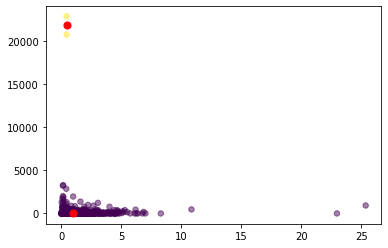

In [24]:

kmeans = KMeans(n_clusters=2).fit(k_means_data)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(k_means_data['List_over_National'], k_means_data['price_change'], c= kmeans.labels_.astype(float), s=30, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()